<a href="https://colab.research.google.com/github/vik0/DDP/blob/master/colabs/langevin_vs_dqn_streaming_bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments comparing performance of Langevin and DQN on bandit environment 

In this experiment, we sweep over different bandit settings (linear bandits with different number of action while the input dimension is fixed to `10`) to compare Langevin streaming algorithm with DQN streaming algorithm.

- We use a linear Gaussian bandit with $18$ actions with standard in the observation noise as $0.01$ 
 
- We use a tabular representation for representing `Q`-values (or reward estimates)

- We found a major flaw in the streaming version of the algorithm. 
$$ \Delta \theta_{t+1} = \epsilon \nabla_{\theta = \theta_t}( L(\theta, \{s_t, a_t, r_t, s_{t+1}\}) + \frac{1}{|D|}\Psi(\theta) ) + \sqrt{\frac{2\epsilon}{|D|}} w_t $$ 
- Let us consider a independent $2$ arm bandit with tabular parametrization to illustrate the problem in the algorithm. In this case, when we pick an arm, update rule of the other arm looks like Langevin used to sample from the prior and NOT the posterior distribution. 

- Nevertheless, we would like to see how performace of different algorithms get effected by using a streaming update. We can see that Langevin performs better than SGD with Adam. But it is strange that we see that Langevin, DQN perform best with 1 sgd step per env step. Could be because we are using a single learning rate for all of them.


In [0]:
# @title imports 
import os
import bsuite 
import numpy as np
import pandas as pd
import plotnine as gg
from bsuite.logging import csv_load

## Streaming version of Langevin 

In [2]:
# @title import deep_sea from csv files 
LANG_RESULTS_DIR='/home/zero/Stan/projects/langTD/bsuite/bsuite/baselines/lang_tf2/results/bandit_custom_streaming'
df_list = []
for directory in os.listdir(LANG_RESULTS_DIR):
    if 'sgd_steps' in directory:
        for opt in ['adam', 'sgd']:
            dir = LANG_RESULTS_DIR+'/' + directory + '/' + opt + '/tabular' 
            df = csv_load.load_one_result_set_with_seed(dir)
            df['sgd_per_step'] = int(directory.split('sgd_steps_')[1])
            df['alg'] = 'langevin'
            df['optimizer'] = opt
            df_list.append(df)
            print('Lang - sgd_steps : {}'.format(directory.split('sgd_steps_')[1]))
DF_lang = pd.concat(df_list)
    
DQN_RESULTS_DIR='/home/zero/Stan/projects/langTD/bsuite/bsuite/baselines/dqn_tf2/results/bandit_custom_streaming'
df_list2 = []
for directory in os.listdir(DQN_RESULTS_DIR):
    if 'sgd_steps' in directory:
        for opt in ['adam', 'sgd']:
            df = csv_load.load_one_result_set_with_seed(DQN_RESULTS_DIR+'/'
                                + directory + '/' + opt + '/tabular')
            df['sgd_per_step'] = int(directory.split('sgd_steps_')[1])
            df['alg'] = 'dqn'
            df['optimizer'] = opt
            df_list2.append(df)
            print('DQN - sgd_steps : {}'.format(directory.split('sgd_steps_')[1]))
DF_dqn = pd.concat(df_list2)    

Lang - sgd_steps : 10
Lang - sgd_steps : 10
Lang - sgd_steps : 1
Lang - sgd_steps : 1
Lang - sgd_steps : 25
Lang - sgd_steps : 25
DQN - sgd_steps : 10
DQN - sgd_steps : 10
DQN - sgd_steps : 1
DQN - sgd_steps : 1
DQN - sgd_steps : 25
DQN - sgd_steps : 25


In [3]:
DF_lang.columns

Index(['steps', 'steps_per_sec', 'episode', 'total_return', 'episode_len',
       'episode_return', 'total_regret', 'episode_regret', 'action',
       'bsuite_id', 'seed_x', 'results_dir', 'bsuite_env', 'seed_y',
       'num_actions', 'noise_var', 'depth', 'width', 'noise_scale',
       'reward_scale', 'height_threshold', 'x_reward_threshold', 'size',
       'memory_length', 'num_bits', 'n_distractor', 'chain_length',
       'sgd_per_step', 'alg', 'optimizer'],
      dtype='object')

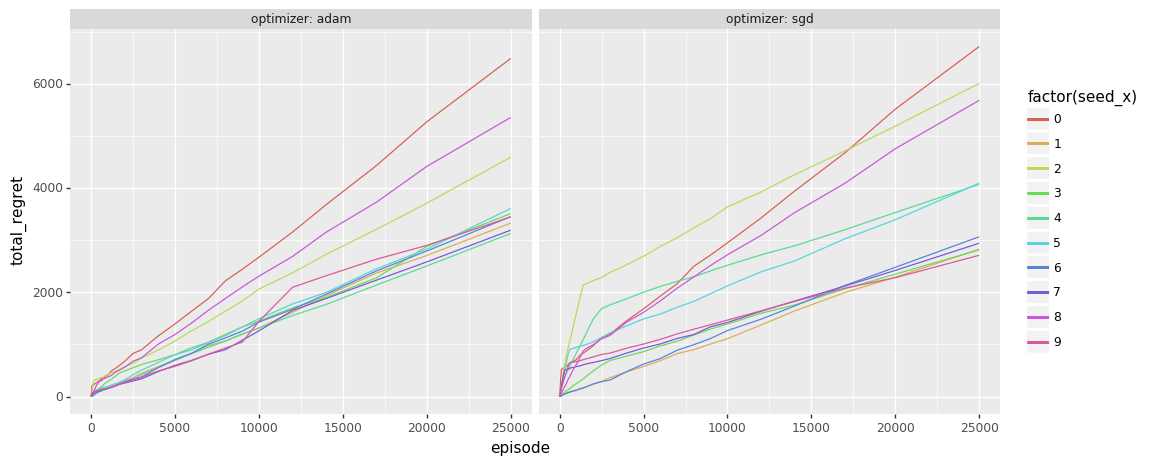

<ggplot: (-9223363269260427292)>

In [6]:
#@title Plot results from dqn with one sgd steps per env step
p = (gg.ggplot(DF_dqn[(DF_dqn.sgd_per_step==1)])
     + gg.aes(x='episode', y='total_regret',
#               group='seed_x',
#               color='factor(episode_len)',
#               fill='factor(episode_len)')
              color='factor(seed_x)')
     + gg.geom_line()
     + gg.facet_wrap(['optimizer'], labeller='label_both')
     + gg.theme(figure_size=(12, 5))
    )
p

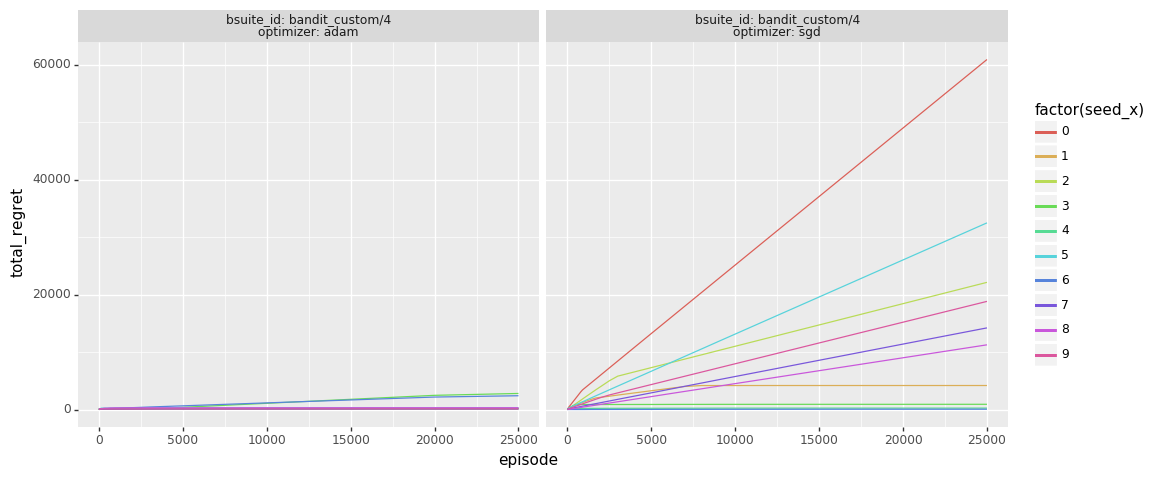

<ggplot: (8767587922766)>

In [8]:
#@title Plot results from langevin with one sgd steps per env step
p = (gg.ggplot(DF_lang[(DF_lang.sgd_per_step==1)])
     + gg.aes(x='episode', y='total_regret',
#               group='seed_x',
#               color='factor(episode_len)',
#               fill='factor(episode_len)')
              color='factor(seed_x)')
     + gg.geom_line()
     + gg.facet_wrap(['bsuite_id', 'optimizer'],
                    #  scales='free',
                     labeller='label_both')
     + gg.theme(figure_size=(12, 5))
    )
p

### Combining both there results 

In [0]:
#@title process data from both algorithms
DF = pd.concat([DF_lang, DF_dqn])
PLT_DF = DF.groupby(['alg', 'bsuite_id', 'episode', 'sgd_per_step', 'optimizer']
                   )['total_return', 'total_regret', 'episode_return'
                    ].mean().reset_index()

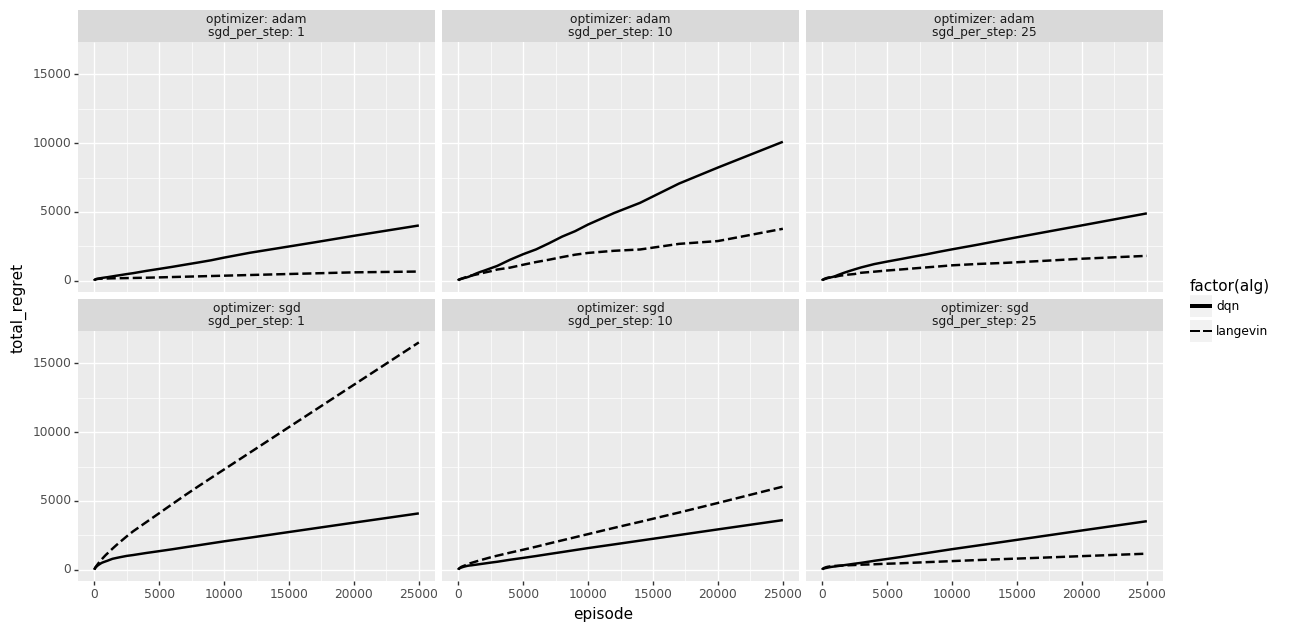

<ggplot: (-9223363269260608992)>

In [14]:
#@title Plot average total regret of Langevin vs epsilon-DQN. We can see that Langevin performs better than SGD with Adam but it is strange that the performance degrades with increase in the number of sgd steps per env step. Could be because of the learning rate. 
p = (gg.ggplot(PLT_DF)
     + gg.aes(x='episode', y='total_regret',
            #   color='factor(bsuite_id)',
              linetype='factor(alg)'
             )
     + gg.geom_line(size=1.0)
#      + gg.scale_y_log10()
     + gg.facet_wrap([ 'optimizer','sgd_per_step',],
                    #  scales='free',
                     labeller='label_both')
     + gg.theme(figure_size=(14, 7))
    )
p

In [0]:
# p.save('mini_batch_lang_vs_dqn.pdf')

^ In most of the cases when `total_return` becomes constant, it is because the parameters have exploded to inifinity.  